### Importing Libraries 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

### Data Exploration & Preprocessing

In [2]:
data = pd.read_csv("C://Users//rahul//OneDrive//Documents//RAHUL//ImagoAI//TASK-ML-INTERN.csv")

# removeing extra whitespaces
data.columns = data.columns.str.strip()
print("Dataset shape:", data.shape)
print("Dataset columns:", data.columns.tolist())

# Check for missing values and getting statistics
print("\nMissing values per column:")
print(data.isnull().sum())
print("\nDataset summary:")
print(data.describe())

Dataset shape: (500, 450)
Dataset columns: ['hsi_id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150',

In [3]:
print(data.columns)

Index(['hsi_id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '439', '440', '441', '442', '443', '444', '445', '446', '447',
       'vomitoxin_ppb'],
      dtype='object', length=450)


In [4]:
# Defining "vomitoxin_ppb" as target value and excluding the identifier "hsi_id" from features.
target = 'vomitoxin_ppb'
features = [col for col in data.columns if col not in ['hsi_id', target]]
print("Number of spectral features:", len(features))

Number of spectral features: 448


In [5]:
# Standardizing the spectral features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

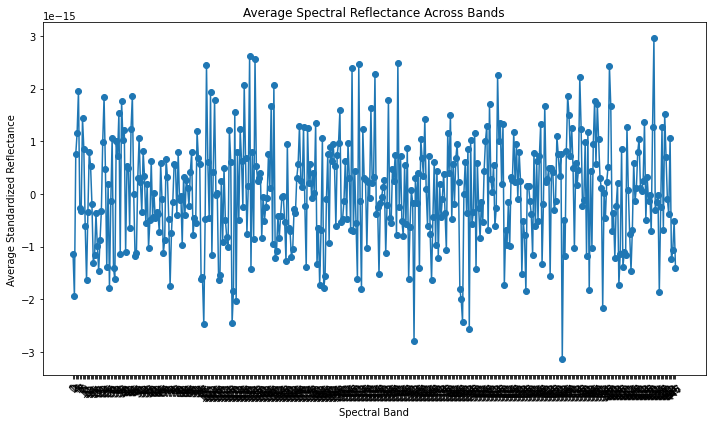

In [6]:
# Visualization of average spectral reflectance across bands
avg_reflectance = np.mean(X_scaled, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(features, avg_reflectance, marker='o')
plt.xlabel('Spectral Band')
plt.ylabel('Average Standardized Reflectance')
plt.title('Average Spectral Reflectance Across Bands')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Dimensionality Reduction using PCA

In [7]:
# Applying PCA to reduce dimensions to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

Explained variance ratio (PC1, PC2): [0.87077909 0.05849069]


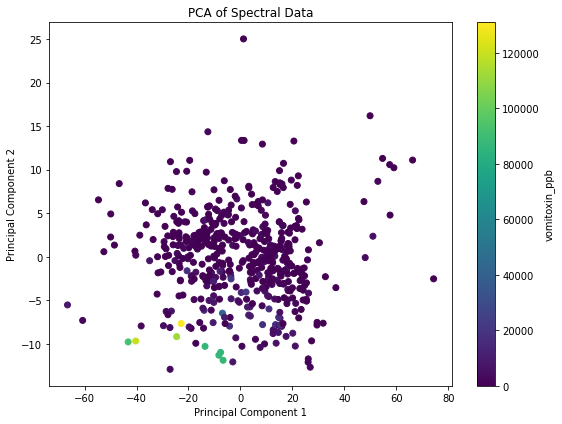

In [8]:
# Scatter plot of PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data[target], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Spectral Data')
cbar = plt.colorbar(scatter)
cbar.set_label('vomitoxin_ppb')
plt.tight_layout()
plt.show()

### Preparing Data for the CNN Model

In [9]:
# Defining x and y
X = X_scaled
y = data[target].values

In [10]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0], "| Testing samples:", X_test.shape[0])

Training samples: 400 | Testing samples: 100


In [11]:
# Reshape the data for 1D CNN: (samples, spectral bands, channels)
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)
print("CNN input shape (training):", X_train_cnn.shape)

CNN input shape (training): (400, 448, 1)


### Building and Training the 1D CNN Model

In [13]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

In [14]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 446, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 223, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 221, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 110, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 7040)              0         
                                                                 
 dense (Dense)               (None, 100)               7

In [16]:
# Model Traning
history = model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
10/10 [==============================] - 1s 38ms/step - loss: 141303648.0000 - mae: 2918.7944 - val_loss: 202952640.0000 - val_mae: 4067.1028
Epoch 2/50
10/10 [==============================] - 0s 23ms/step - loss: 140906000.0000 - mae: 2879.8884 - val_loss: 202084400.0000 - val_mae: 4009.8911
Epoch 3/50
10/10 [==============================] - 0s 25ms/step - loss: 139807936.0000 - mae: 2827.9014 - val_loss: 200114976.0000 - val_mae: 3956.3464
Epoch 4/50
10/10 [==============================] - 0s 22ms/step - loss: 138348160.0000 - mae: 2876.0059 - val_loss: 197059232.0000 - val_mae: 3993.2285
Epoch 5/50
10/10 [==============================] - 0s 23ms/step - loss: 135937024.0000 - mae: 3067.1382 - val_loss: 194262496.0000 - val_mae: 4117.8101
Epoch 6/50
10/10 [==============================] - 0s 22ms/step - loss: 134312128.0000 - mae: 3303.0125 - val_loss: 191860960.0000 - val_mae: 4235.3452
Epoch 7/50
10/10 [==============================] - 0s 20ms/step - loss: 132500072

### Model Evaluation

In [17]:
# Evaluating the model on the testing set
loss, mae_metric = model.evaluate(X_test_cnn, y_test)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae_metric)

4/4 [==============================] - 0s 5ms/step - loss: 104938448.0000 - mae: 3457.5400
Test Loss (MSE): 104938448.0
Test MAE: 3457.5400390625


In [18]:
# Generating Predictions
y_pred = model.predict(X_test_cnn)

4/4 [==============================] - 0s 5ms/step


In [19]:
# Calculating RMSE and R² Score
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Model Performance Metrics:
Mean Absolute Error (MAE): 3457.540094754696
Root Mean Squared Error (RMSE): 10243.946344819158
R² Score: 0.6245938966252853


In [23]:
# Calculating Accuracy, Precision, Recall, F1 Score
threshold = np.median(y_train)
y_test_class = (y_test > threshold).astype(int)
y_pred_class = (y_pred.flatten() > threshold).astype(int)

accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)

print("\nClassification Metrics (after thresholding):")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Classification Metrics (after thresholding):
Accuracy: 0.65
Precision: 0.6129032258064516
Recall: 0.7755102040816326
F1 Score: 0.6846846846846848


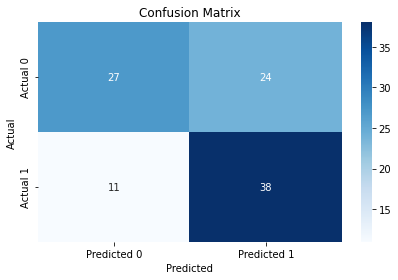

In [26]:
# confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Plotting the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

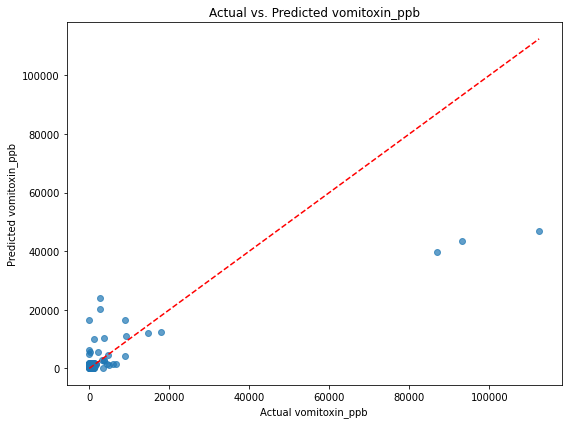

In [20]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual vomitoxin_ppb')
plt.ylabel('Predicted vomitoxin_ppb')
plt.title('Actual vs. Predicted vomitoxin_ppb')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.tight_layout()
plt.show()

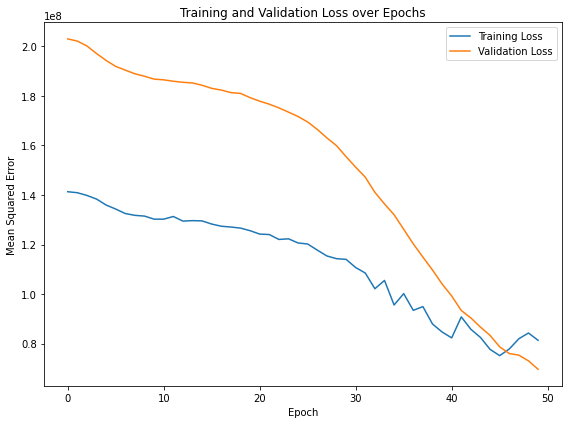

In [21]:
# Plotting training and validation loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.tight_layout()
plt.show()